In [1]:

import pickle
import numpy as np
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import sys
import os

import warnings
warnings.filterwarnings('ignore')

with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

# Unpack the variables
all_users_daily = data["df"]
demographic = data["demographics"]



## Visualize baseline scores by histograms

ace_total: 5.00 x 4.00 inches
phq_total: 5.00 x 4.00 inches
gds_total: 5.00 x 4.00 inches
gad_total: 5.00 x 4.00 inches


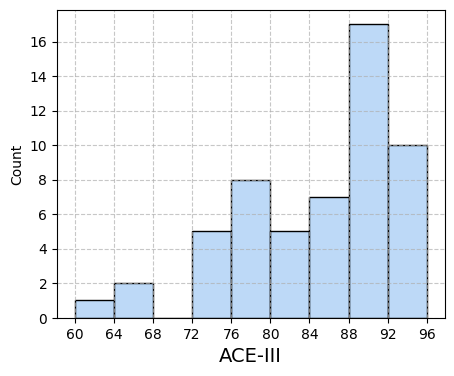

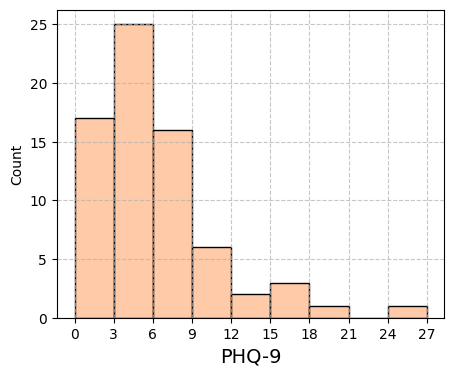

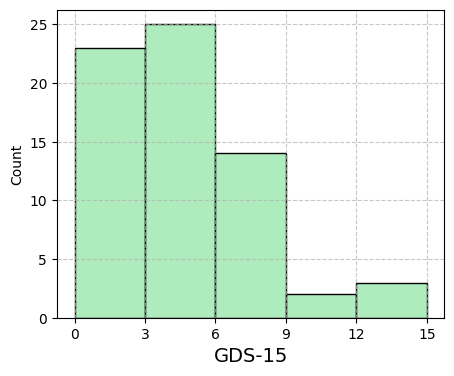

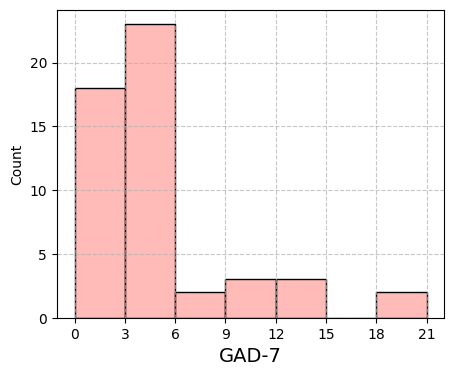

In [2]:
## Mental Health assesments histograms
range_dict = {'ace_total':(60,96,10),'phq_total':(0,27,10),'gds_total':(0,15,6),'gad_total':(0,21,8)}
ass_names = {"ace_total":"ACE-III","phq_total":"PHQ-9","gds_total":"GDS-15","gad_total":"GAD-7"}
colors = sns.color_palette("pastel", n_colors=4)
for n,col in enumerate(['ace_total','phq_total','gds_total','gad_total']):
    plt.figure(figsize=(5, 4))
    values = demographic[col].values.astype(int)
    values = values[values>0]
    bin_edges = np.linspace(range_dict[col][0], range_dict[col][1], num=range_dict[col][2])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    sns.histplot(values, bins=bin_edges, alpha=0.7,color=colors[n])

    plt.xlabel(ass_names[col],fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks([bin_edges[i] for i in range(len(bin_edges))])
    plt.savefig('hist_'+col+'.pdf',bbox_inches='tight')
    fig = plt.gcf()
    width, height = fig.get_size_inches()
    print(f"{col}: {width:.2f} x {height:.2f} inches")

### Histograms stratified by sex

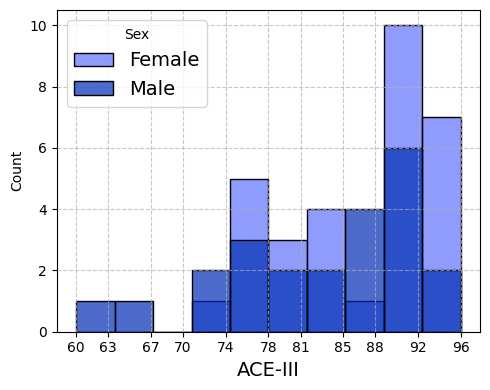

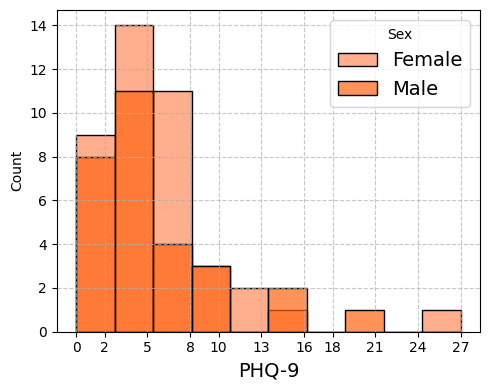

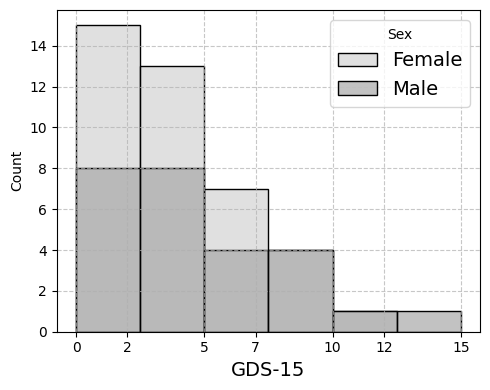

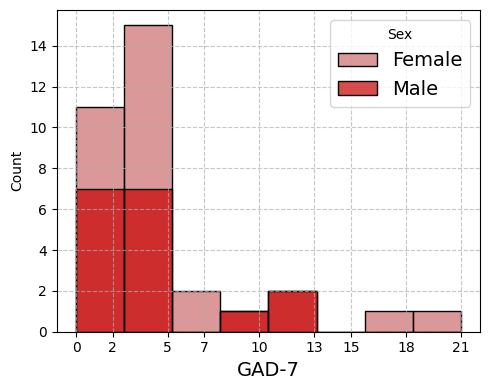

In [3]:
## Mental Health assesments histograms (Stratified by Sex)
range_dict = {
    'ace_total': (60, 96, 10),
    'phq_total': (0, 27, 10),
    'gds_total': (0, 15, 6),
    'gad_total': (0, 21, 8)
}
color_map = {
    'ace_total': {'Male':"#002DB4", 'Female': "#6173FD"}, 
    'phq_total': {'Male': "#FF6411", 'Female': "#FF8C5EE2"},   
    'gds_total': {'Male': '#A9A9A9', 'Female': '#D3D3D3'}, 
    'gad_total': {'Male': "#C80000", 'Female': "#CB6D6DFF"},   
}
ass_names = {
    'ace_total': 'ACE-III',
    'phq_total': 'PHQ-9',
    'gds_total': 'GDS-15',
    'gad_total': 'GAD-7'
}

sex_labels = demographic['Sex'].dropna().unique()

for col in ['ace_total', 'phq_total', 'gds_total', 'gad_total']:
    plt.figure(figsize=(5, 4))
    bin_edges = np.linspace(
        range_dict[col][0],
        range_dict[col][1],
        num=range_dict[col][2] + 1
    )

    for sex in sex_labels:
        values = demographic[demographic['Sex'] == sex][col].dropna().astype(int)
        values = values[values > 0]
        color = color_map.get(col, {}).get(sex, 'gray')
        # Plot histogram
        sns.histplot(values, bins=bin_edges, kde=False, color=color, label=str(sex), alpha=0.7)

    plt.xlabel(ass_names[col], fontsize=14)
    plt.xticks([int(bin_edges[i]) for i in range(len(bin_edges))])
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.legend(title='Sex',fontsize=14)
    plt.tight_layout()
    plt.savefig(f'hist_stratified_{col}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()


### Histograms stratified by Age group

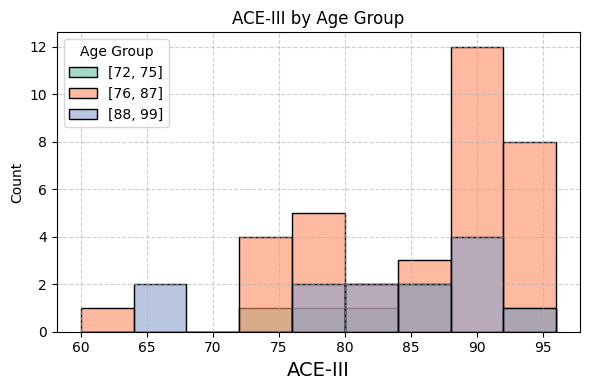

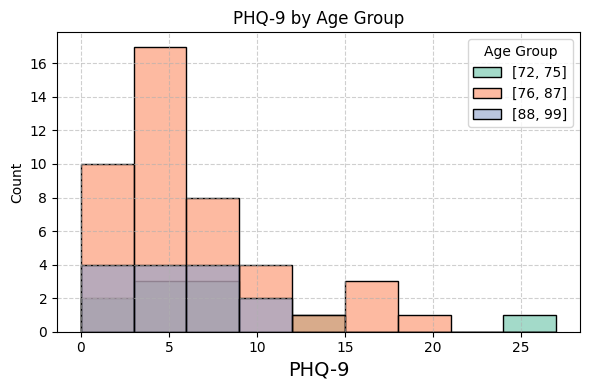

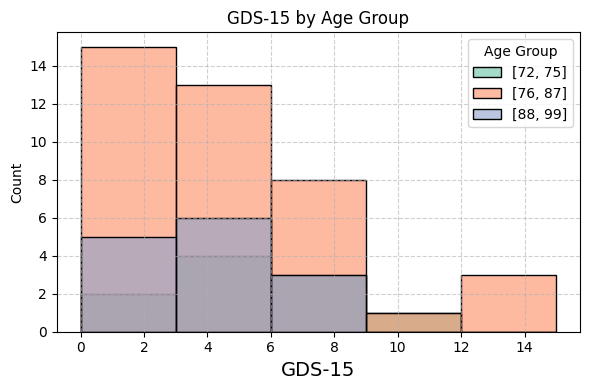

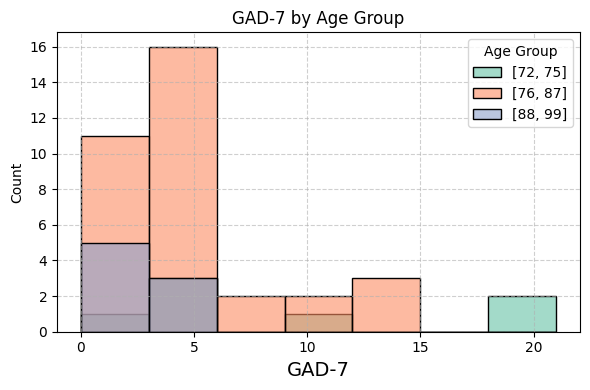

In [4]:
## Mental Health assesments histograms (Stratified by Age)
age_groups = sorted(demographic['Age group'].dropna().unique())
palette = sns.color_palette("Set2", n_colors=len(age_groups))

for col in ['ace_total', 'phq_total', 'gds_total', 'gad_total']:
    plt.figure(figsize=(6, 4))
    bin_edges = np.linspace(range_dict[col][0], range_dict[col][1], num=range_dict[col][2])
    for age_group, color in zip(age_groups, palette):
        subset = demographic[(demographic['Age group'] == age_group) & (demographic[col] > 0)]
        values = subset[col].astype(int)
        sns.histplot(values, bins=bin_edges, alpha=0.6, label=age_group, color=color)

    plt.xlabel(ass_names[col], fontsize=14)
    plt.ylabel('Count')
    plt.title(f'{ass_names[col]} by Age Group')
    plt.legend(title='Age Group')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'hist_{col}_by_agegroup.pdf')

## Visualize the number of participants in the study along time axis

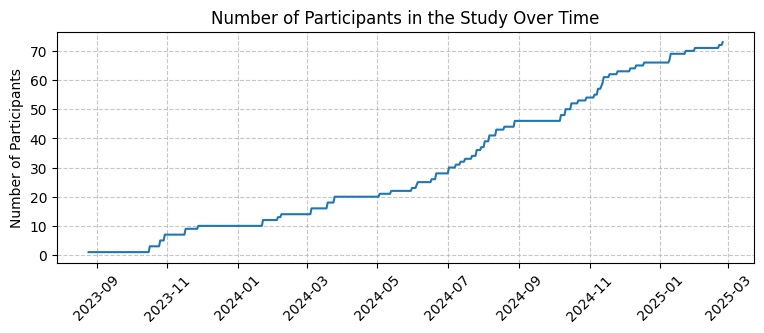

In [5]:

demographic['phq_date']=pd.to_datetime(demographic['phq_date'])

# Group by join date to count new users per day
daily_users = demographic.groupby('phq_date').size().reset_index(name='new_users')

# Create a continuous date range covering the entire study period
date_range = pd.date_range(start=demographic['phq_date'].min(), end=demographic['phq_date'].max())

# Build a DataFrame with the full date range and merge with the new users data
daily_users_full = pd.DataFrame({'phq_date': date_range})
daily_users_full = daily_users_full.merge(daily_users, on='phq_date', how='left')
daily_users_full['new_users'] = daily_users_full['new_users'].fillna(0)

# Compute the cumulative number of users over time
daily_users_full['cumulative_users'] = daily_users_full['new_users'].cumsum()

# Plot the cumulative number of users
plt.figure(figsize=(9, 3))
plt.plot(daily_users_full['phq_date'], daily_users_full['cumulative_users'], 
          linestyle='-')
# plt.xlabel('Date')
plt.ylabel('Number of Participants')
plt.title('Number of Participants in the Study Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.savefig('num_participants.svg',bbox_inches='tight')

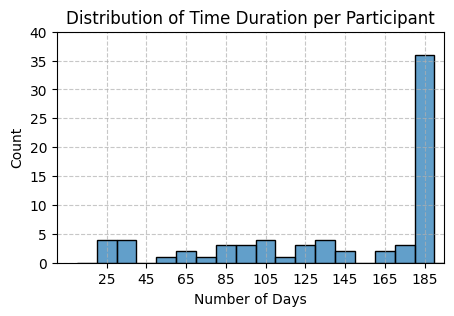

In [6]:
user_durations = all_users_daily.groupby('user_id')['date'].agg(lambda x: x.nunique())
plt.figure(figsize=(5, 3))
bin_edges = np.linspace(10, 200, num=20)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

sns.histplot(user_durations.values, bins=bin_edges, alpha=0.7)

plt.xlabel('Number of Days')
plt.ylim(0,40)
plt.xlim(0,195)
plt.title('Distribution of Time Duration per Participant')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([bin_centers[i] for i in range(len(bin_centers)) if i%2==1])
plt.savefig('overview_days.svg',bbox_inches='tight')

## Visualize variable distributions by sex groups

       Watch_Steps          sleep_duration         Watch_Heart Rate_mean      
              mean      std           mean     std                  mean   std
Sex                                                                           
Female      881.66  1266.85         415.34  135.27                 69.89  9.35
Male       1167.70  1915.93         435.23  138.61                 65.91  7.49


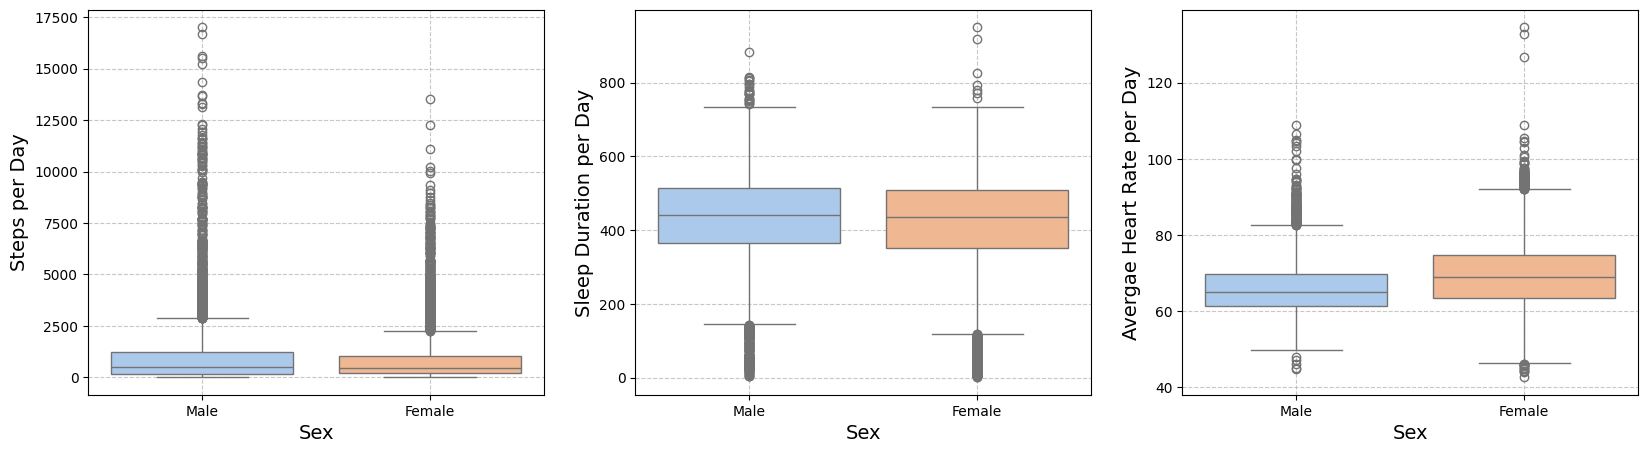

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(x='Sex', y='Watch_Steps', data=all_users_daily, ax=axes[0], palette="pastel")
sns.boxplot(x='Sex', y='sleep_duration', data=all_users_daily, ax=axes[1], palette="pastel")
sns.boxplot(x='Sex', y='Watch_Heart Rate_mean', data=all_users_daily, ax=axes[2], palette="pastel")

axes[0].set_xlabel("Sex",fontsize=14)
axes[0].set_ylabel("Steps per Day",fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].set_xlabel("Sex",fontsize=14)
axes[1].set_ylabel("Sleep Duration per Day",fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

axes[2].set_xlabel("Sex",fontsize=14)
axes[2].set_ylabel("Avergae Heart Rate per Day",fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)

cols = ['Steps','Sleep','HR']
for i, ax in enumerate(axes):
    tight_bbox = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("sex_"+cols[i]+".pdf", bbox_inches=tight_bbox)


# Compute mean and std by Sex for selected columns
summary_stats = all_users_daily.groupby('Sex')[['Watch_Steps', 'sleep_duration', 'Watch_Heart Rate_mean']].agg(['mean', 'std'])
summary_stats = summary_stats.round(2)
print(summary_stats)

## Visualize variable distributions by Age groups

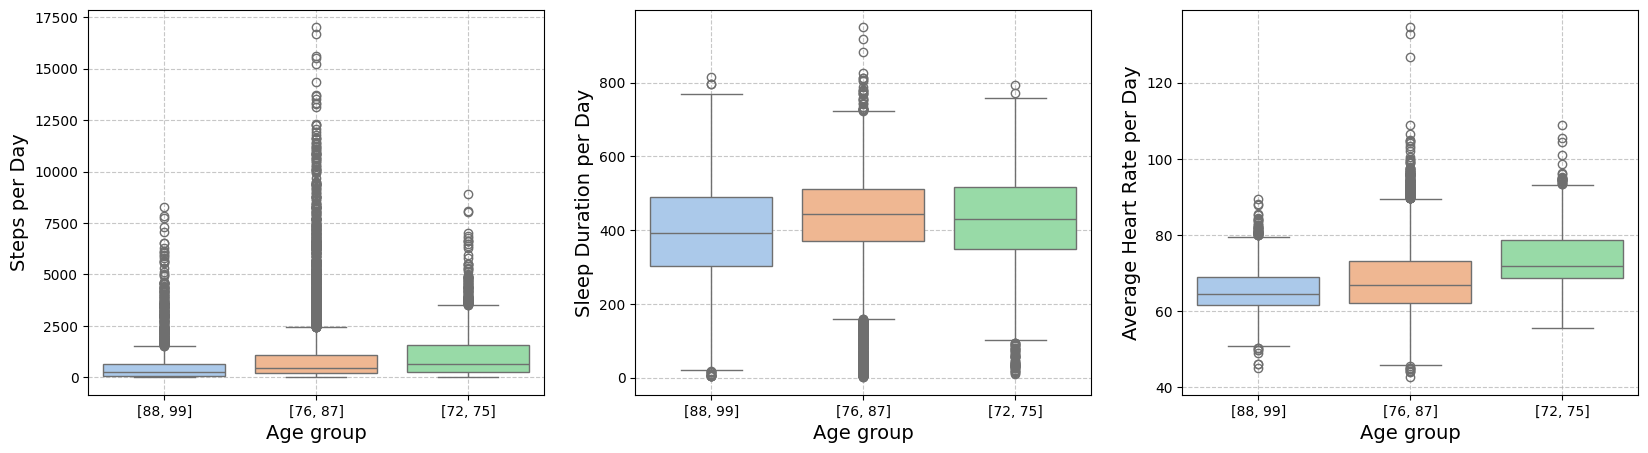

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(x='Age group', y='Watch_Steps', data=all_users_daily, ax=axes[0], palette="pastel")
sns.boxplot(x='Age group', y='sleep_duration', data=all_users_daily, ax=axes[1], palette="pastel")
sns.boxplot(x='Age group', y='Watch_Heart Rate_mean', data=all_users_daily, ax=axes[2], palette="pastel")

axes[0].set_xlabel("Age group", fontsize=14)
axes[0].set_ylabel("Steps per Day", fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].set_xlabel("Age group", fontsize=14)
axes[1].set_ylabel("Sleep Duration per Day", fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

axes[2].set_xlabel("Age group", fontsize=14)
axes[2].set_ylabel("Average Heart Rate per Day", fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)

cols = ['Steps', 'Sleep', 'HR']
for i, ax in enumerate(axes):
    tight_bbox = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("age_"+cols[i]+".pdf", bbox_inches=tight_bbox)


## Visualize Correlations between assessments and sleep states in a given time window

In [9]:
def filter_sleep_data(sleep_daily, uid, ass_date, time_window):
    """ Extract sleep data within the specified time window for a user. """
    ass_date = pd.to_datetime(ass_date)
    sleep_range = sleep_daily.loc[
        (sleep_daily.user_id == uid) &
        (sleep_daily.date > ass_date.date()) &
        (sleep_daily.date <= (ass_date + pd.Timedelta(days=time_window)).tz_localize('UTC').date())
    ]

    return sleep_range

In [10]:
def compute_sleep_statistics(sleep_range,sleep_stats):
    """ Compute average and standard deviation of sleep metrics. """
    if sleep_range.empty:
        return None, None

    sleep_avg = sleep_range[sleep_stats].mean(axis=0)
    sleep_std = sleep_range[sleep_stats].std(axis=0)
    
    return sleep_avg, sleep_std

In [11]:
def process_single_record(i, uid, sleep_daily, score_summary, ass_cols, sleep_stats):
    """ Process a single record: extract sleep data and fill statistics. """

    sleep_avg_cols = [st + "_avg" for st in sleep_stats]
    sleep_std_cols = [st + "_std" for st in sleep_stats]

    # Handle special date column naming
    if "ace_total_6months" in ass_cols:
        ass_date_col = "ace_date_6months"
    else:
        ass = ass_cols[0].split("_total")[0]  # General fallback (e.g., phq_total → phq)
        ass_date_col = ass + "_date"

    ass_date = score_summary.loc[score_summary.user_id == uid, ass_date_col].values[0]
    sleep_range = filter_sleep_data(sleep_daily, uid, ass_date, time_window)
    sleep_avg, sleep_std = compute_sleep_statistics(sleep_range, sleep_stats)

    if sleep_avg is None:
        print(f"No matched time window: {uid}, {len(sleep_range)}")
        return None

    matched_row = {"user_id": uid}
    matched_row.update(score_summary.loc[score_summary.user_id == uid, ["user_id"] + ass_cols].iloc[0].to_dict())
    matched_row.update(dict(zip(sleep_avg_cols, sleep_avg.values)))
    matched_row.update(dict(zip(sleep_std_cols, sleep_std.values)))

    return matched_row




In [12]:
def compute_correlations(ass, ass_sleep_corr, time_window,sleep_stats,file_name='sleep'):
    """ Computes and saves correlations across time windows. """
    sleep_avg_cols = [st + "_avg" for st in sleep_stats]
    sleep_std_cols = [st + "_std" for st in sleep_stats]
    ass_sleep_corr = np.vstack(ass_sleep_corr)

    ass_sleep_corr_df = pd.DataFrame(ass_sleep_corr, columns=[ass.upper()] + sleep_avg_cols + sleep_std_cols)
    return ass_sleep_corr_df

In [13]:
def get_assessment_columns(score_summary, ass):
    """ Retrieve assessment columns matching the given type and suffix. """
    columns = score_summary.columns.tolist()
    if ass == "ace":
        cols = [c for c in columns if "ace_total" == c]
    elif ass == "ace_total_6monhts":
        cols = [c for c in columns if "ace_total_6months" == c]
    else:
        cols = [c for c in columns if ass in c and "total" in c]
    if not cols:
        print(f"[WARNING] No assessment columns found for '{ass}'. Available columns: {columns}")
    return cols

def match_sleep_assessment(ass, score_summary, sleep_daily, time_window,sleep_stats,file_name='sleep'):
    """ Processes a single assessment type across different time windows. """
    ass_sleep_corr = []
    sleep_avg_cols = [st + "_avg" for st in sleep_stats]
    sleep_std_cols = [st + "_std" for st in sleep_stats]

    ass_cols = get_assessment_columns(score_summary, ass)
    uids = score_summary.user_id.unique()
    print(ass_cols,sleep_stats)
    matched_rows = []
    for i, uid in enumerate(uids):
        matched_row = process_single_record(i, uid, sleep_daily, score_summary, ass_cols=ass_cols,sleep_stats=sleep_stats)
        if matched_row:
            matched_rows.append(matched_row)

    matched_df = pd.DataFrame(matched_rows)
    matched_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    ass_sleep_corr.append(matched_df[ass_cols + sleep_avg_cols + sleep_std_cols].values)

    return compute_correlations(ass, ass_sleep_corr, time_window,sleep_stats,file_name)


In [14]:
# Sleep statistics and column names
sleep_stats = ["wakeup", "light", "deep", "REM"]
# Assessment categories and time windows
assessments = ["phq", "gad", "gds","ace", "ace_total_6monhts"]
time_window = 7
ass_sleep_corr_map = []
# Run processing for all assessments
for ass in assessments:
    corr_map = match_sleep_assessment(ass, demographic, all_users_daily, time_window,sleep_stats)
    ass_sleep_corr_map.append(corr_map.corr()[ass.upper()])

ass_sleep_corr_map = pd.concat(ass_sleep_corr_map,axis=1).drop([a.upper() for a in assessments],axis=0)


['phq_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 31489056, 0
['gad_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 4fc82b26, 0
No matched time window: 21b5f52d, 0
No matched time window: 4523540f, 0
No matched time window: f5ca38f7, 0
No matched time window: 6f4b6612, 0
No matched time window: 7077831c, 0
No matched time window: c2356069, 0
No matched time window: b7a56873, 0
No matched time window: eb1e33e8, 0
No matched time window: 403c387d, 0
No matched time window: e29c9c18, 0
No matched time window: c6f3ac57, 0
No matched time window: 7a61b537, 0
No matched time window: 5e86cb4b, 0
No matched time window: 73475cb4, 0
No matched time window: 44cb730c, 0
No matched time window: 3ff1feb9, 0
No matched time window: 811786ad, 0
No matched time window: 31489056, 0
No matched time window: 1a656259, 0
No matched time window: 031b4af5, 0
No matched time window: 2858dcd1, 0
No

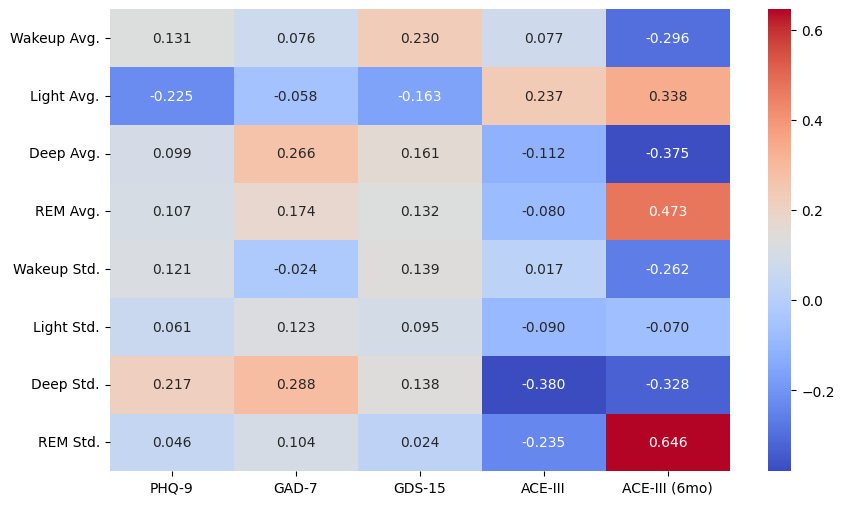

In [15]:
# Custom display names for assessments
assessments = ["phq", "gad", "gds", "ace", "ace_6months"]
assessment_labels = {
    "phq": "PHQ-9",
    "gad": "GAD-7",
    "gds": "GDS-15",
    "ace": "ACE-III",
    "ace_6months": "ACE-III (6mo)"
}

# Create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(ass_sleep_corr_map, cmap='coolwarm', annot=True, fmt=".3f")

# Apply custom axis labels
ax.set_xticklabels([assessment_labels[a] for a in assessments])
ax.set_yticklabels([
    'Wakeup Avg.', 'Light Avg.', 'Deep Avg.', 'REM Avg.',
    'Wakeup Std.', 'Light Std.', 'Deep Std.', 'REM Std.'
])

# Save to file
plt.savefig(f"sleep_{time_window}d_assess_corr_map.pdf", bbox_inches='tight')

### Visualize Correlations between assessments and sleep states (Stratified by Sex)

Processing Age Group: Female
['phq_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 31489056, 0
['gad_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 21b5f52d, 0
No matched time window: 4523540f, 0
No matched time window: f5ca38f7, 0
No matched time window: b7a56873, 0
No matched time window: eb1e33e8, 0
No matched time window: c6f3ac57, 0
No matched time window: 5e86cb4b, 0
No matched time window: 73475cb4, 0
No matched time window: 44cb730c, 0
No matched time window: 811786ad, 0
No matched time window: 31489056, 0
No matched time window: 1a656259, 0
No matched time window: 2858dcd1, 0
No matched time window: ddd9cd98, 0
['gds_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 21b5f52d, 0
No matched time window: 4523540f, 0
No matched time window: f5ca38f7, 0
No matched time window: b7a56873, 0
No matched time window: eb1e33e8, 0
No matched time window: c6f3ac57, 0
No matched time window: 5e86cb4b, 0
No matched time window: 73475cb4

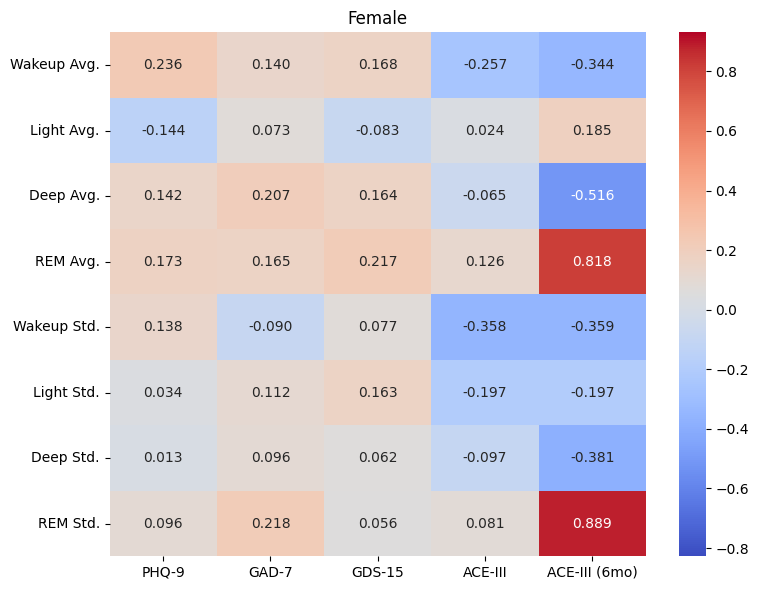

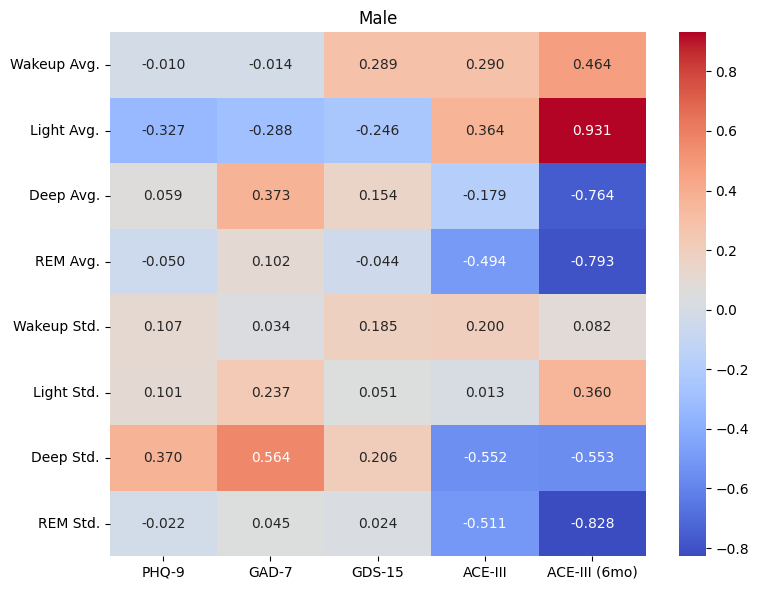

In [16]:
demographic = demographic.dropna(subset=['Sex'])
sex = demographic['Sex'].unique()
#assessments = ["phq", "gad", "gds", "ace"]
#If you want to correlate with 6 months ace data, comment previous line and activate the following:
assessments = ["phq", "gad", "gds", "ace", "ace_total_6monhts"]
time_window = 7
sleep_stats = ["wakeup", "light", "deep", "REM"]

grouped_corr_maps = {}
for sex in sex:
    print(f"Processing Age Group: {sex}")
    demo_sex = demographic[demographic['Sex'] == sex]
    
    ass_sleep_corr_map = []
    for ass in assessments:
        corr_map = match_sleep_assessment(ass, demo_sex, all_users_daily, time_window, sleep_stats)
        ass_sleep_corr_map.append(corr_map.corr()[ass.upper()])
    
    age_corr_df = pd.concat(ass_sleep_corr_map, axis=1).drop([a.upper() for a in assessments], axis=0)
    grouped_corr_maps[sex] = age_corr_df

all_corr_values = pd.concat(grouped_corr_maps.values()).values.flatten()
vmin = all_corr_values.min()
vmax = all_corr_values.max()

for sex, corr_df in grouped_corr_maps.items():
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(
        corr_df,
        cmap='coolwarm',
        annot=True,
        fmt=".3f",
        vmin=vmin,
        vmax=vmax  # ensures shared color scale
    )
    ax.set_title(f"{sex}")
    # ax.set_xticklabels(['PHQ-9','GAD-7','GDS-15','ACE-III'])
    ax.set_xticklabels(['PHQ-9','GAD-7','GDS-15','ACE-III', "ACE-III (6mo)" ])
    ax.set_yticklabels(['Wakeup Avg.','Light Avg.','Deep Avg.','REM Avg.','Wakeup Std.','Light Std.','Deep Std.','REM Std.'])
    plt.tight_layout()
    plt.savefig(f"Sleep_{sex}_{time_window}d_corr_map.pdf")

## Visualize Correlations between assessments and watch data in a given time window

In [17]:
# Sleep statistics and column names
watch_act = ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']

# Assessment categories and time windows
assessments = ["phq", "gad", "gds","ace"]

time_window = 7
ass_sleep_corr_map = []
# Run processing for all assessments
for ass in assessments:
    corr_map = match_sleep_assessment(ass, demographic, all_users_daily, time_window,watch_act)
    ass_sleep_corr_map.append(corr_map.corr()[ass.upper()])
ass_sleep_corr_map = pd.concat(ass_sleep_corr_map,axis=1).drop([a.upper() for a in assessments],axis=0)

['phq_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 31489056, 0
['gad_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 21b5f52d, 0
No matched time window: 4523540f, 0
No matched time window: f5ca38f7, 0
No matched time window: 6f4b6612, 0
No matched time window: 7077831c, 0
No matched time window: c2356069, 0
No matched time window: b7a56873, 0
No matched time window: eb1e33e8, 0
No matched time window: 403c387d, 0
No matched time window: e29c9c18, 0
No matched time window: c6f3ac57, 0
No matched time window: 7a61b537, 0
No matched time window: 5e86cb4b, 0
No matched time window: 73475cb4, 0
No matched time window: 44cb730c, 0
No matched time window: 3ff1feb9, 0
No matched time window: 811786ad, 0
No matched time window: 31489056, 0
No matched time window: 1a656259, 0
No

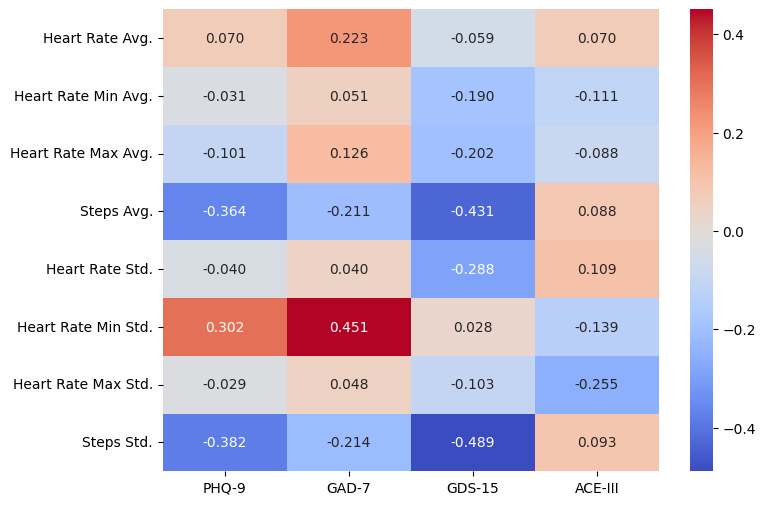

In [18]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(ass_sleep_corr_map,cmap='coolwarm',annot=True, fmt=".3f")
ax.set_xticklabels(['PHQ-9','GAD-7','GDS-15','ACE-III'])
ax.set_yticklabels(['Heart Rate Avg.','Heart Rate Min Avg.','Heart Rate Max Avg.','Steps Avg.','Heart Rate Std.','Heart Rate Min Std.','Heart Rate Max Std.','Steps Std.'])
plt.savefig("watch"+'_'+str(time_window)+"d_assess_corr_map.pdf",bbox_inches='tight')

### Visualize Correlations between assessments and watch data (Stratified by Sex)

Processing Age Group: Female
['phq_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 31489056, 0
['gad_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 21b5f52d, 0
No matched time window: 4523540f, 0
No matched time window: f5ca38f7, 0
No matched time window: b7a56873, 0
No matched time window: eb1e33e8, 0
No matched time window: c6f3ac57, 0
No matched time window: 5e86cb4b, 0
No matched time window: 73475cb4, 0
No matched time window: 44cb730c, 0
No matched time window: 811786ad, 0
No matched time window: 31489056, 0
No matched time window: 1a656259, 0
No matched time window: 2858dcd1, 0
No matched time window: ddd9cd98, 0
['gds_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 21b5f52d, 0
No matched time window: 4523540f, 0
No matched time window: f5ca38f7, 0
No matched tim

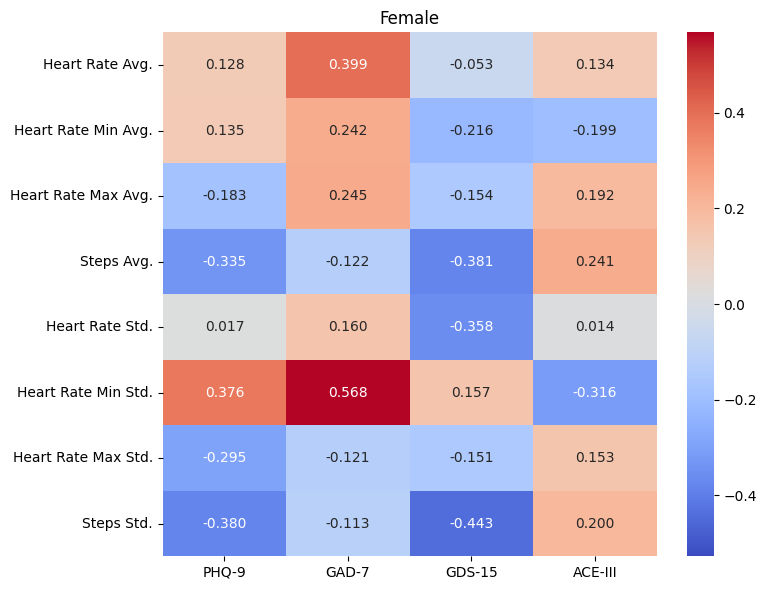

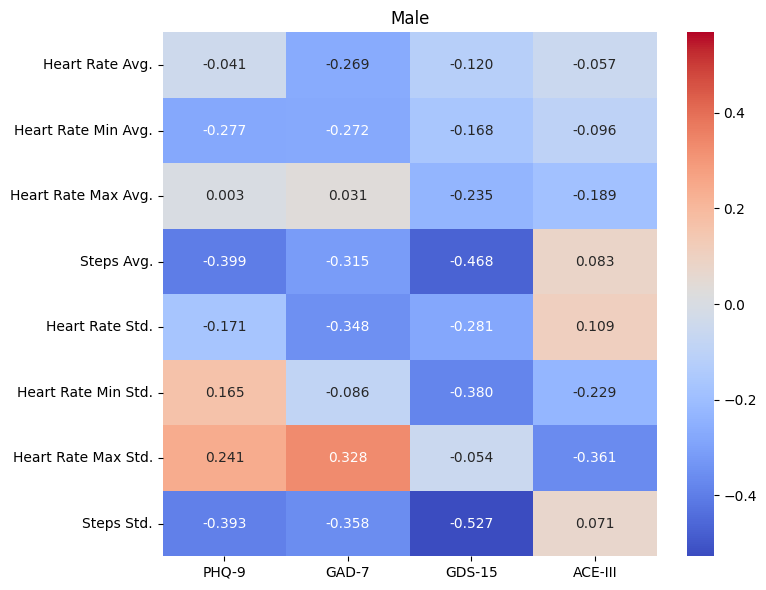

In [19]:
demographic = demographic.dropna(subset=['Sex'])

sex = demographic['Sex'].unique()
assessments = ["phq", "gad", "gds", "ace"]
time_window = 7
watch_act = ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']

grouped_corr_maps = {}

for sex in sex:
    print(f"Processing Age Group: {sex}")
    demo_sex = demographic[demographic['Sex'] == sex]
    
    ass_sleep_corr_map = []
    for ass in assessments:
        corr_map = match_sleep_assessment(ass, demo_sex, all_users_daily, time_window, watch_act)
        ass_sleep_corr_map.append(corr_map.corr()[ass.upper()])
    
    age_corr_df = pd.concat(ass_sleep_corr_map, axis=1).drop([a.upper() for a in assessments], axis=0)
    grouped_corr_maps[sex] = age_corr_df

# Get global min and max for consistent color scale
all_corr_values = pd.concat(grouped_corr_maps.values()).values.flatten()
vmin = all_corr_values.min()
vmax = all_corr_values.max()

for sex, corr_df in grouped_corr_maps.items():
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(
        corr_df,
        cmap='coolwarm',
        annot=True,
        fmt=".3f",
        vmin=vmin,
        vmax=vmax  # ensures shared color scale
    )
    ax.set_title(f"{sex}")
    ax.set_xticklabels(['PHQ-9','GAD-7','GDS-15','ACE-III'])
    ax.set_yticklabels(['Heart Rate Avg.','Heart Rate Min Avg.','Heart Rate Max Avg.','Steps Avg.','Heart Rate Std.','Heart Rate Min Std.','Heart Rate Max Std.','Steps Std.'])
    plt.tight_layout()
    plt.savefig(f"Watch_{sex}_{time_window}d_corr_map.pdf")

## Visualize sleep trajectories of individual participants

In [20]:
def obtain_moving_avg(signal,window_size=7,mode='valid',axis=-1):
    
    # Initialize an array to hold the moving average
    moving_avg = np.empty(signal.shape)
    moving_squared_mean = np.empty(signal.shape)

    # Compute the cumulative average for the initial part
    for i in range(window_size-1):
        moving_avg[...,i] = np.mean(signal[...,:i+1],axis=axis)
        moving_squared_mean[...,i] = np.mean(signal[...,:i+1],axis=axis)**2
        
    # Compute the moving average for the remaining part
    moving_avg[...,window_size-1:] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode=mode), axis=axis, arr=signal)

    # Compute rolling squared mean using convolution
    data_squared = signal ** 2
    moving_squared_mean[...,window_size-1:] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode=mode), axis=axis, arr=data_squared)
    
    # Calculate rolling standard deviation
    moving_average_squared = moving_avg ** 2
    moving_std = np.sqrt(moving_squared_mean - moving_average_squared)

    return moving_avg, moving_std

In [21]:
def get_user_daily_df(uid):
    tmp = all_users_daily.loc[all_users_daily.user_id==uid]
    if len(tmp)==0:
        print('no sleep data for user id ',uid)
        return
    start_date = tmp['date'].min()
    end_date = start_date + pd.Timedelta(days=185) ## half a year range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    tmp = tmp[(tmp['date'] >= start_date) & (tmp['date'] < end_date)]
    tmp = tmp.set_index('date')

    tmp_full = tmp.reindex(date_range)
    tmp_full.index.name = 'date'
    return tmp_full,start_date,end_date

In [22]:
def plot_user_sleep_traj(user_id):
    tmp_full,start_date,end_date = get_user_daily_df(user_id)
    if tmp_full is None:
        return
    
    sleep_cols = ['light','deep','REM','wakeup']
    moving_avg = obtain_moving_avg(tmp_full[sleep_cols].values.transpose(),window_size=7,mode='valid',axis=-1)
   
    fig,ax=plt.subplots(figsize=[20,4])
    ax.plot(tmp_full.index,moving_avg[0][0],linewidth=3)
    ax.plot(tmp_full.index,moving_avg[0][1],linewidth=3)
    ax.plot(tmp_full.index,moving_avg[0][2],linewidth=3)
    ax.plot(tmp_full.index,moving_avg[0][3],linewidth=3)
    ax.set_ylim(0,600)
    ax.set_xlim(start_date- pd.Timedelta(days=1),end_date+ pd.Timedelta(days=0))
    tick_dates = [start_date+relativedelta(months=1*n) for n in range(0,7)]
    ax.set_xticks(tick_dates)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    scores = ["ace_","phq_","gds_","gad_"]
    # Add vertical lines and annotations
    days_offset = 0
    sfx = "baseline"
        
    vline_date = start_date + pd.Timedelta(days=days_offset)
    for tdt in tick_dates:
        ax.axvline(tdt, color="red", linestyle="--", linewidth=1)

    
    ax.text(vline_date, 580, f" ACE-III:{demographic.loc[demographic.user_id==uid,scores[0]+'total'].values[0]}\n PHQ-9: {demographic.loc[demographic.user_id==uid,scores[1]+'total'].values[0]} \n GDS-15: {demographic.loc[demographic.user_id==uid,scores[2]+'total'].values[0]} \n GAD-7: {demographic.loc[demographic.user_id==uid,scores[3]+'total'].values[0]}",  
                color="red", fontsize=15, rotation=0, verticalalignment='top')
    

    ax.set_title("UID: "+uid,fontsize=15)
    ax.legend(['light','deep','REM','wakeup'],loc=[.88,0.56],fontsize=16)
    plt.ylabel('Duration (s)')
    plt.savefig("sleep_vis_"+user_id+".svg",bbox_inches="tight")
    plt.show()
    plt.close()

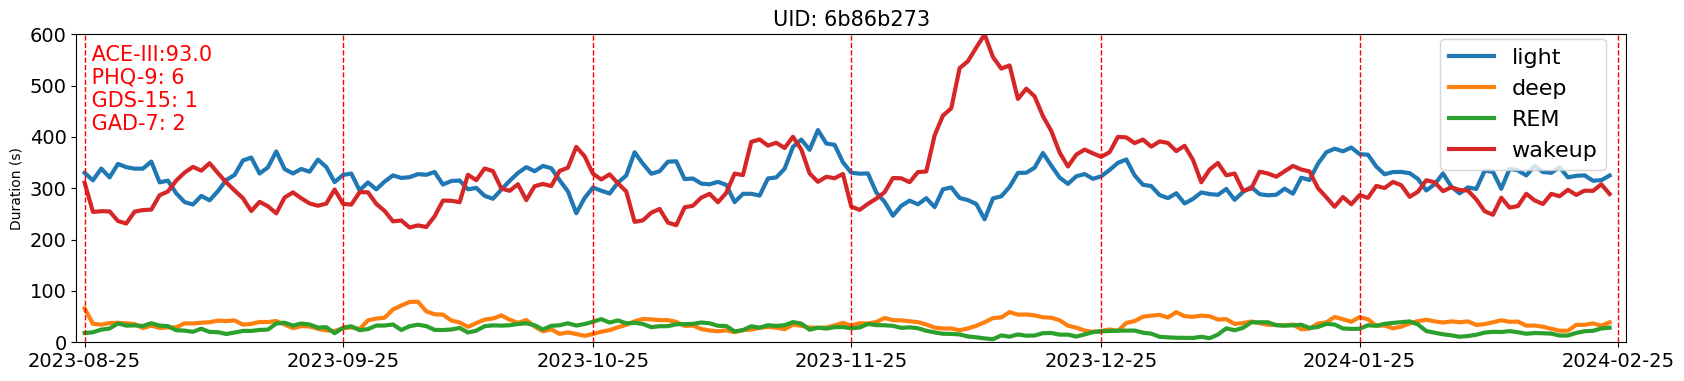

In [23]:
uid = '6b86b273'
plot_user_sleep_traj(uid)

## Visualize steps trajectory for invidual participants

In [24]:
def plot_user_steps_traj(uid):
    tmp = all_users_daily.loc[all_users_daily.user_id==uid]
    if len(tmp)==0:
        print('no sleep data for user id ',uid)
        return
    start_date = tmp['date'].min()
    end_date = start_date + pd.Timedelta(days=185)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    tmp = tmp[(tmp['date'] >= start_date) & (tmp['date'] < end_date)]
    tmp = tmp.set_index('date')

    tmp_full = tmp.reindex(date_range)
    tmp_full.index.name = 'date'
    
    moving_avg = obtain_moving_avg(tmp_full['Watch_Steps'].values.transpose(),window_size=7,mode='valid',axis=-1)


    fig,ax=plt.subplots(figsize=[20,4])
    ax.plot(tmp_full.index,moving_avg[0],linewidth=3)
    ax.set_xlim(start_date- pd.Timedelta(days=1),end_date+ pd.Timedelta(days=0))
    tick_dates = [start_date+relativedelta(months=1*n) for n in range(0,7)]
    ax.set_xticks(tick_dates)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    scores = ["ace_","phq_","gds15_","gad_"]
    days_offset = 0
    sfx = "baseline"
        
    for tdt in tick_dates:
        ax.axvline(tdt, color="red", linestyle="--", linewidth=1)
    
  

    ax.set_title("UID: "+uid,fontsize=15)
    ax.legend(['Steps'],loc=[.88,0.86],fontsize=16)
    plt.savefig("step_vis_"+uid+".svg",bbox_inches="tight")
    plt.show()
    plt.close()

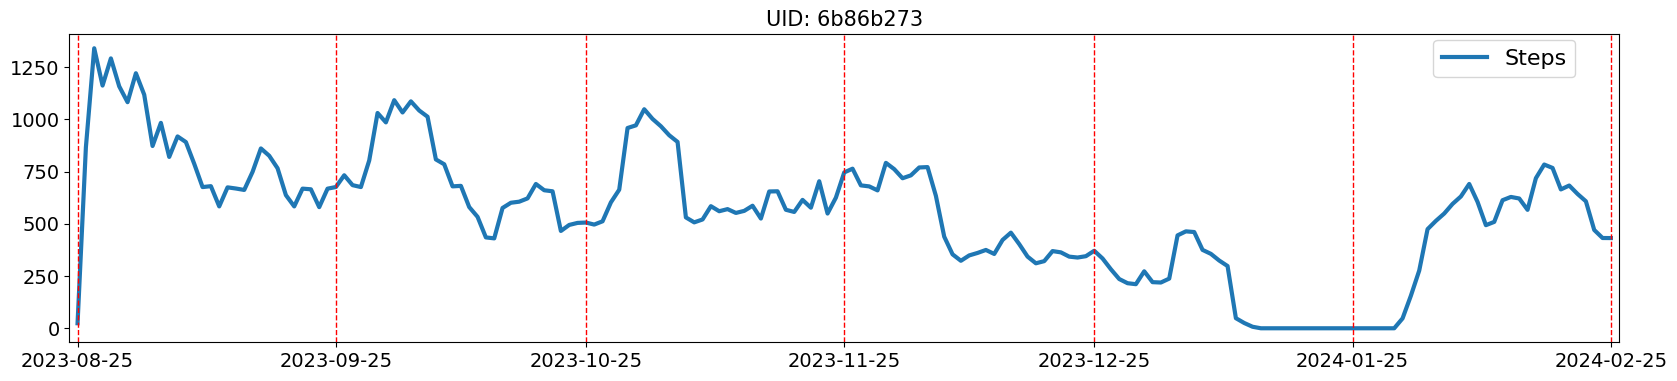

In [25]:
uid = '6b86b273'
plot_user_steps_traj(uid)

In [26]:
def plot_user_sleep_traj(user_id, ax):
    tmp_full, start_date, end_date = get_user_daily_df(user_id)
    if tmp_full is None:
        return

    # Ensure datetime types
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    sleep_cols = ['light', 'deep', 'REM', 'wakeup']
    moving_avg = obtain_moving_avg(tmp_full[sleep_cols].values.T, window_size=7, mode='valid', axis=-1)

    # Plot each sleep stat
    for i, label in enumerate(sleep_cols):
        ax.plot(tmp_full.index, moving_avg[0][i], linewidth=3, label=label)

    ax.set_ylabel("Sleep Duration (s)", fontsize=14, labelpad=10, color='black')
    ax.set_ylim(0, 600)

    # Parse ACE-III assessment dates safely
    ace_date_str = demographic.loc[demographic.user_id == user_id, "ace_date"].values[0]
    ace_6mo_date_str = demographic.loc[demographic.user_id == user_id, "ace_date_6months"].values[0]
    ace_date = pd.to_datetime(ace_date_str, dayfirst=True, errors='coerce')
    ace_6mo_date = pd.to_datetime(ace_6mo_date_str, dayfirst=True, errors='coerce')

    # Extend x-axis range to include ACE-III 6mo + 10 days
    x_end = max(end_date, ace_6mo_date + pd.Timedelta(days=10))
    ax.set_xlim(start_date - pd.Timedelta(days=1), x_end)

    # X-axis tick marks (monthly)
    tick_dates = [start_date + relativedelta(months=n) for n in range(7)]
    ax.set_xticks(tick_dates)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Red monthly vertical lines
    for tdt in tick_dates:
        ax.axvline(tdt, color="red", linestyle="--", linewidth=1)

    # Assessment vertical lines
    ax.axvline(ace_date, color="blue", linestyle="--", linewidth=2)
    ax.axvline(ace_6mo_date - pd.Timedelta(days=3), color="blue", linestyle="--", linewidth=2)

    # Get scores
    ace_score = demographic.loc[demographic.user_id == user_id, 'ace_total'].values[0]
    ace_6mo_score = demographic.loc[demographic.user_id == user_id, 'ace_total_6months'].values[0]
    phq_score = demographic.loc[demographic.user_id == user_id, 'phq_total'].values[0]
    gds_score = demographic.loc[demographic.user_id == user_id, 'gds_total'].values[0]
    gad_score = demographic.loc[demographic.user_id == user_id, 'gad_total'].values[0]

    # Annotate baseline assessments
    ax.text(
        ace_date, 580,
        f"ACE-III: {ace_score}\nPHQ-9: {phq_score}\nGDS-15: {gds_score}\nGAD-7: {gad_score}",
        color="blue", fontsize=14, verticalalignment='top'
    )

    # Annotate ACE-III 6mo slightly shifted left and down
    ax.text(
        ace_6mo_date - pd.Timedelta(days=3), 520,
        f"ACE-III \n(6mo): {ace_6mo_score}",
        color="blue", fontsize=14, verticalalignment='top'
    )

    # Title and legend
    ax.set_title("UID: " + user_id, fontsize=15)
    ax.legend(loc='lower right', fontsize=16)

In [27]:
def plot_user_steps_traj(user_id, ax):
    tmp = all_users_daily.loc[all_users_daily.user_id == user_id]
    if tmp.empty:
        print('No steps data for user id', user_id)
        return

    # Parse start/end dates
    start_date = pd.to_datetime(tmp['date'].min())
    end_date = start_date + pd.Timedelta(days=185)

    # Reindex to ensure full date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    tmp = tmp.set_index('date').reindex(date_range)
    tmp.index.name = 'date'

    # Smooth steps with 7-day moving average
    moving_avg = obtain_moving_avg(tmp['Watch_Steps'].values.T, window_size=7, mode='valid', axis=-1)

    # Plot
    ax.plot(tmp.index, moving_avg[0], linewidth=3, label='Steps')

    # Parse ACE assessment dates
    ace_date_str = demographic.loc[demographic.user_id == user_id, "ace_date"].values[0]
    ace_6mo_date_str = demographic.loc[demographic.user_id == user_id, "ace_date_6months"].values[0]
    ace_date = pd.to_datetime(ace_date_str, dayfirst=True, errors='coerce')
    ace_6mo_date = pd.to_datetime(ace_6mo_date_str, dayfirst=True, errors='coerce')

    # Extend x-axis to include 10 days after ACE-III 6mo
    x_end = max(end_date, ace_6mo_date + pd.Timedelta(days=10))
    ax.set_xlim(start_date - pd.Timedelta(days=1), x_end)

    # X-axis monthly ticks
    tick_dates = [start_date + relativedelta(months=n) for n in range(7)]
    ax.set_xticks(tick_dates)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Vertical dashed lines for each month
    for tdt in tick_dates:
        ax.axvline(tdt, color="red", linestyle="--", linewidth=1)

    # Add ACE assessment vertical lines
    ax.axvline(ace_date, color="blue", linestyle="--", linewidth=2, label="ACE-III Baseline")
    ax.axvline(ace_6mo_date - pd.Timedelta(days=3), color="blue", linestyle="--", linewidth=2, label="ACE-III (6mo)")


    # Labels and legend
    ax.set_ylabel("Steps", fontsize=14)


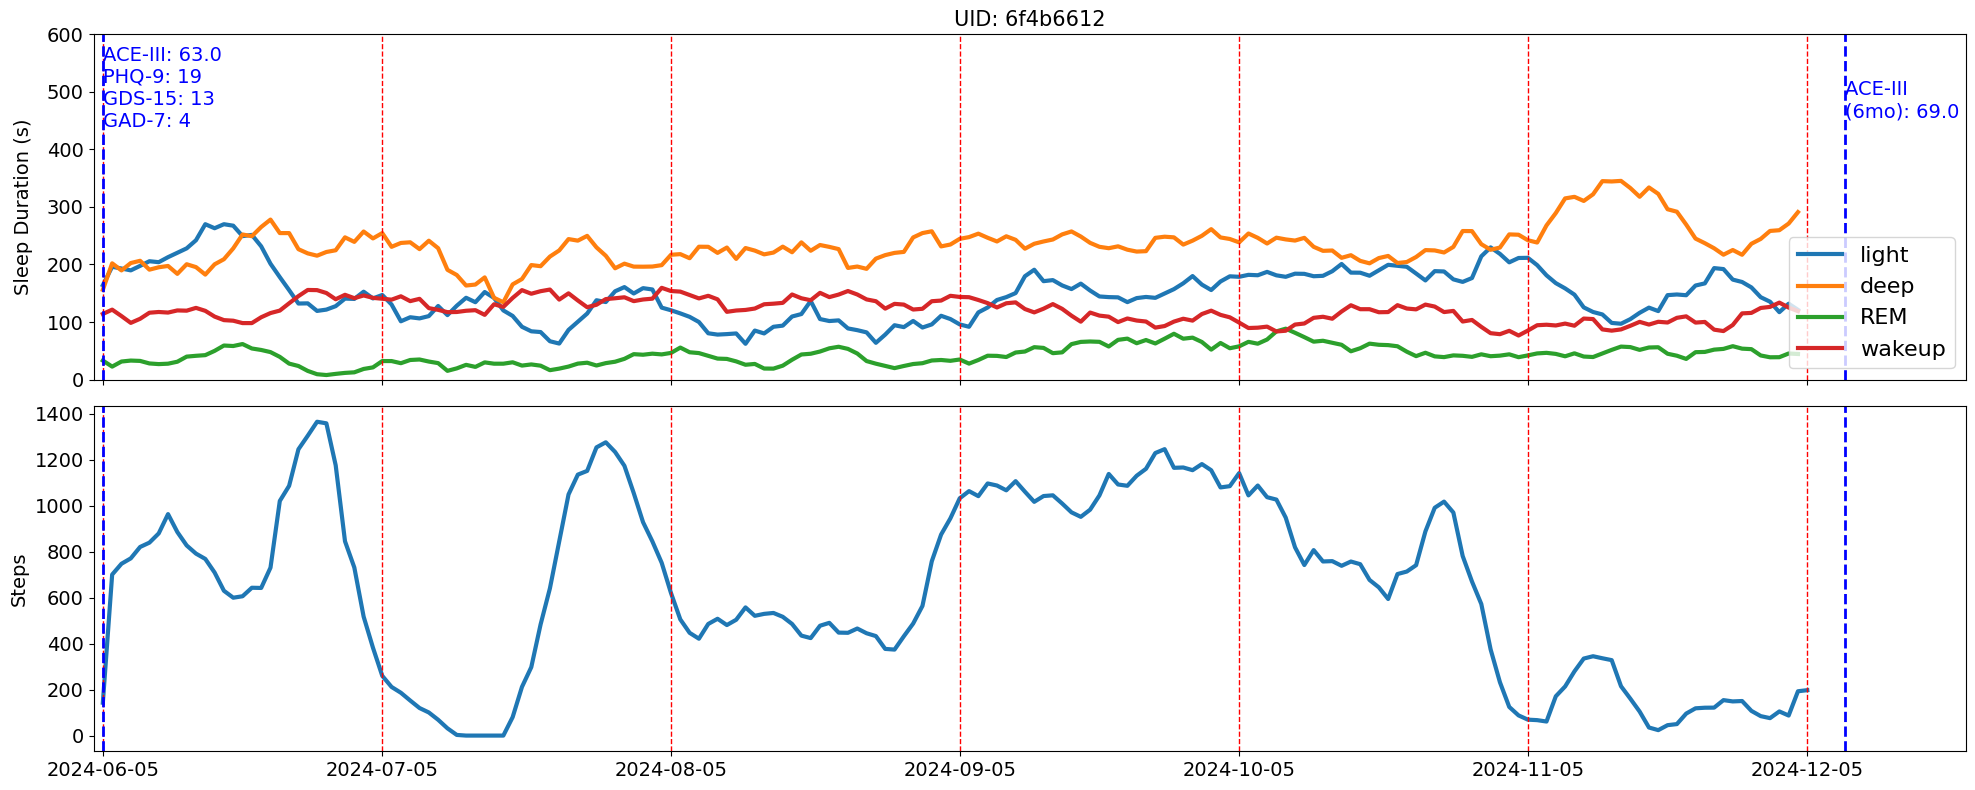

In [28]:
def plot_combined_sleep_and_steps(user_id):
    fig, axes = plt.subplots(nrows=2, figsize=(20, 8), sharex=True)
    
    plot_user_sleep_traj(user_id, axes[0])
    plot_user_steps_traj(user_id, axes[1])
    
    plt.tight_layout()
    plt.savefig("vis_" + user_id + ".pdf", bbox_inches="tight")
    plt.show()
    plt.close()

uid = '6f4b6612'
plot_combined_sleep_and_steps(uid)